In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
from modules.representation_schemes import enc1d_features, get_PTR_features
from modules.function import get_metrics, pymatgen_comp, get_elem_count, data_generator_vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from modules.model_select import rmse, corr
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics
import json
import pickle
import torch
from uncertainties import ufloat
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
ys_df_loc = 'dataset/yield_strength.csv'
ys_df = pd.read_csv(ys_df_loc, index_col=0)
comps = ys_df['Composition'].values
process = ys_df['As-cast/other'].values.reshape(-1,1)
phase = ys_df['Single/MultiPhase'].values
single_phase = pd.get_dummies(phase).values[:,1].reshape(-1,1)
temp = ys_df['Temperature (Celcius)'].values.reshape(-1,1)
y = ys_df['Yield Strength'].values
samples_per_bin, bins, = np.histogram(ys_df['Yield Strength'], bins=np.arange(100,1000,100)) 
min_bin_size = samples_per_bin.min()
n_bins = len(samples_per_bin)
ys_df['bin_name'] = np.digitize(ys_df['Yield Strength'].values,bins)

pmg_comps = pymatgen_comp(comps)
additional = np.concatenate([process,single_phase,temp],axis=1)

In [5]:
results_loc = 'results/hea_ys_general'
if not os.path.exists(results_loc):
    os.mkdir(results_loc)

In [6]:
with open('results/hea_ys_transfer/pca_results_ys.pkl','rb') as fid: ##95% explained variance
    pca_dict = pickle.load(fid)

## Random Subsampling

In [7]:
filename = 'misc/hea_ys_random_subsampling_split.json'
create_new = False
if os.path.exists(filename) and not create_new:
    with open(filename,'rb') as fid:
        kfold_dict_random_subsampling = pickle.load(fid)
        print('Split file loaded')
else:
    np.random.seed(0)
    kfold_dict_random_subsampling = {}
    for i in np.geomspace(0.01,0.99,10):
        remove_inds_list = []
        retain_inds_list = []
        to_retain = int(len(comps)*i)
        for j in range(20):
            remaining_inds = np.random.choice(len(comps),to_retain, replace=False)
            remove_inds = list(set(np.arange(len(comps))) - set(remaining_inds))
            remove_inds_list.append(remove_inds)
            retain_inds_list.append(remaining_inds)
        kfold_dict_random_subsampling[np.round(i,2)] = {'remove':remove_inds_list,'retain':retain_inds_list}

    with open(filename,'wb') as fid:
        pickle.dump(kfold_dict_random_subsampling,fid)
    print('Split file written!')

Split file loaded


## Fixed components

In [8]:
np.random.seed(0)
dset = data_generator_vec(pymatgen_comp(comps))
methods = ['baseline','RF','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
fixed_inds = [5,10,20]
ind_dict = {}
for ind in fixed_inds:
    method_dict = {}
    for method in methods:
        if method in ['baseline','RF']:
            features = dset.real_data
        else:
            if method == 'atomic':
                extracted = enc1d_features(pmg_comps,'atomic')
            elif method == 'random':
                extracted = enc1d_features(pmg_comps,'random')
            elif method == 'random-tr':
                extracted = enc1d_features(pmg_comps,'random-tr')
            elif method == 'pettifor':
                extracted = enc1d_features(pmg_comps,'pettifor')
            elif method == 'mod_pettifor':
                extracted = enc1d_features(pmg_comps,'mod_pettifor')
            elif method == 'PTR':
                extracted = get_PTR_features(pmg_comps)
            elif method =='dense':
                extracted = enc1d_features(pmg_comps,'dense')
            pca = PCA(n_components=ind, whiten=True)
            features = pca.fit_transform(extracted)
        features = np.concatenate((features,additional),axis=1)
        random_subsampling_dict = {}
        for k in kfold_dict_random_subsampling.keys():
            holdout_test = kfold_dict_random_subsampling[k]['remove']
            retained = kfold_dict_random_subsampling[k]['retain']
            rmse_list, r_list = [],[]
            if method == 'baseline':
                baseline_model = Pipeline([('Scaler', StandardScaler()),('MLP',MLPRegressor((42,42,42),batch_size=64,random_state=0))])
            else:

                baseline_model = RandomForestRegressor(random_state=0, n_jobs=-1)
            for i, (train_inds, test_inds) in enumerate(zip(*[retained,holdout_test])):
                train_features = features[train_inds]
                train_y = y[train_inds]
                baseline_model.fit(train_features,train_y)
                yte_pred_holdout = baseline_model.predict(features[test_inds])
                rmse_list.append(rmse(yte_pred_holdout,y[test_inds]))
                r_list.append(corr(yte_pred_holdout,y[test_inds]))
            random_subsampling_dict[k] = {'rmse': rmse_list , 'r': r_list}
        method_dict[method] = random_subsampling_dict
    ind_dict[ind] = method_dict

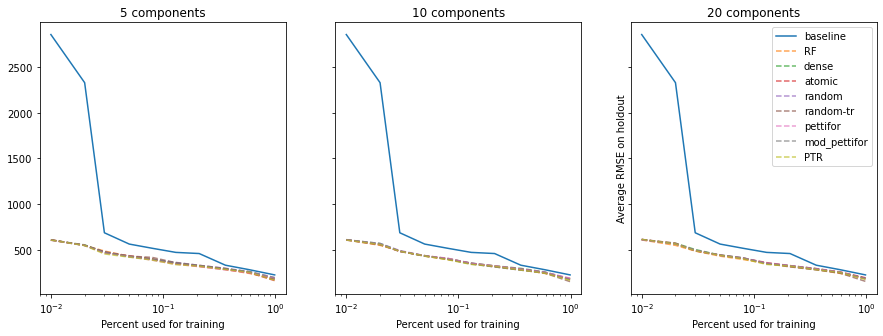

In [9]:
fig,ax  = plt.subplots(1,3,figsize= (15,5), sharex = True,sharey = True)
ax = ax.ravel()
for j,c in enumerate(ind_dict.keys()):
    method_dict = ind_dict[c]
    for method in method_dict.keys():
        random_subsampling_dict = method_dict[method]
        mean_list = []
        std_list = []
        for i in random_subsampling_dict.keys():
            mean = np.mean(random_subsampling_dict[i]['rmse'])
            std = np.std(random_subsampling_dict[i]['rmse'])
            mean_list.append(mean)
            std_list.append(std)
        if method != 'baseline':
            style = '--'
            alpha = 0.7
        else:
            style = '-'
            alpha = 1
        ax[j].errorbar(random_subsampling_dict.keys(),mean_list,label = method, linestyle = style, alpha = alpha)
        ax[j].set_xscale('log')
        ax[j].set_xlabel('Percent used for training')
        ax[j].set_title(f'{c} components')
plt.ylabel('Average RMSE on holdout')
plt.legend()

## Fixed variance

In [10]:
np.random.seed(0)
dset = data_generator_vec(pymatgen_comp(comps))
methods = ['baseline','RF','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
fixed_var = [0.9,0.95,0.99]
var_dict = {}
for var in fixed_var:
    method_dict = {}
    for method in methods:
        if method in ['baseline','RF']:
            features = dset.real_data
        else:
            if method == 'atomic':
                extracted = enc1d_features(pmg_comps,'atomic')
            elif method == 'random':
                extracted = enc1d_features(pmg_comps,'random')
            elif method == 'random-tr':
                extracted = enc1d_features(pmg_comps,'random-tr')
            elif method == 'pettifor':
                extracted = enc1d_features(pmg_comps,'pettifor')
            elif method == 'mod_pettifor':
                extracted = enc1d_features(pmg_comps,'mod_pettifor')
            elif method == 'PTR':
                extracted = get_PTR_features(pmg_comps)
            elif method =='dense':
                extracted = enc1d_features(pmg_comps,'dense')
            ind = pca_dict[var][method]
            pca = PCA(n_components=ind, whiten=True)
            features = pca.fit_transform(extracted)
        features = np.concatenate((features,additional),axis=1)
        random_subsampling_dict = {}
        for k in kfold_dict_random_subsampling.keys():
            holdout_test = kfold_dict_random_subsampling[k]['remove']
            retained = kfold_dict_random_subsampling[k]['retain']
            rmse_list, r_list = [],[]
            if method == 'baseline':
                baseline_model = Pipeline([('Scaler', StandardScaler()),('MLP',MLPRegressor((42,42,42),batch_size=64,random_state=0))])
            else:

                baseline_model = RandomForestRegressor(random_state=0, n_jobs=-1)
            for i, (train_inds, test_inds) in enumerate(zip(*[retained,holdout_test])):
                train_features = features[train_inds]
                train_y = y[train_inds]
                baseline_model.fit(train_features,train_y)
                yte_pred_holdout = baseline_model.predict(features[test_inds])
                rmse_list.append(rmse(yte_pred_holdout,y[test_inds]))
                r_list.append(corr(yte_pred_holdout,y[test_inds]))
            random_subsampling_dict[k] = {'rmse': rmse_list , 'r': r_list}
        method_dict[method] = random_subsampling_dict
    var_dict[var] = method_dict

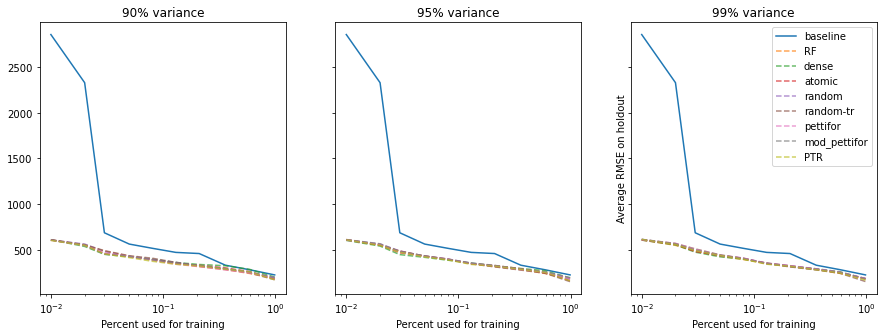

In [11]:
fig,ax  = plt.subplots(1,3,figsize= (15,5), sharex = True,sharey = True)
ax = ax.ravel()
for j,c in enumerate(var_dict.keys()):
    method_dict = var_dict[c]
    for method in method_dict.keys():
        random_subsampling_dict = method_dict[method]
        mean_list = []
        std_list = []
        for i in random_subsampling_dict.keys():
            mean = np.mean(random_subsampling_dict[i]['rmse'])
            std = np.std(random_subsampling_dict[i]['rmse'])
            mean_list.append(mean)
            std_list.append(std)
        if method != 'baseline':
            style = '--'
            alpha = 0.7
            
        else:
            style = '-'
            alpha = 1
        ax[j].errorbar(random_subsampling_dict.keys(),mean_list,label = method, linestyle = style, alpha = alpha)
        ax[j].set_xscale('log')
        ax[j].set_xlabel('Percent used for training')
        ax[j].set_title(f'{int(c*100)}% variance')
plt.ylabel('Average RMSE on holdout')
plt.legend()

In [ ]:
results_dict = {
    'fixed_inds':ind_dict,
    'fixed_var':var_dict
}

with open(os.path.join(results_loc,'random_subsampling_hea_ys.json'),'w') as fid:
    json.dump(results_dict,fid)